<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import os
import numpy as np
import logging
from pycomp.log.log_config import log_config

In [2]:
# Definindo variáveis do projeto
DATA_PATH = 'titanic_data/'
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'

# Lendo base de treino e verificando conteúdo
df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_FILENAME))
print(f'Dimensões da base de treino: {df_train.shape}')
df_train.head()

Dimensões da base de treino: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Importando classes
from pycomp.ml.transformers import FormataColunas, FiltraColunas, DefineTarget, \
                                   EliminaDuplicatas, SplitDados, DummiesEncoding
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Parâmetros de execução
initial_features = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# Construindo pipeline inicial
initial_pipeline = Pipeline([
    ('formatter', FormataColunas()),
    ('selector', FiltraColunas(features=initial_features)),
    ('target_prep', DefineTarget(target_col='survived', pos_class=1)),
    ('dup_dropper', EliminaDuplicatas()),
    ('splitter', SplitDados(target='target'))
])

# Executando pipeline inicial
X_train, X_test, y_train, y_test = initial_pipeline.fit_transform(df_train)

# Separando features por tipo primitivo
num_features = [col for col, dtype in X_train.dtypes.items() if dtype != 'object']
cat_features = [col for col, dtype in X_train.dtypes.items() if dtype == 'object']

# Construindo pipeline numérico
num_pipeline = Pipeline([
    ('na_filler', SimpleImputer(strategy='median'))
])

# Construindo pipeline categórico
cat_pipeline = Pipeline([
    ('encoder', DummiesEncoding(dummy_na=True))
])

# Construindo pipeline final de prep
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Executando pipeline completo nos dados de treino e de teste
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.fit_transform(X_test)

# Retornando features
pipeline_encoder = full_pipeline.named_transformers_['cat'].named_steps['encoder']
cat_encoded_features = pipeline_encoder.features_after_encoding
features = num_features + cat_encoded_features

# Verificando resultados
print(f'Dimensões da base de treino X_train_prep: {X_train_prep.shape}')
print(f'Dimensões da base de teste X_test_prep: {X_test_prep.shape}')
print(f'Quantidade de features consideradas: {len(features)}')

Dimensões da base de treino X_train_prep: (624, 12)
Dimensões da base de teste X_test_prep: (156, 12)
Quantidade de features consideradas: 12


/home/paninit/anaconda3/lib/python3.7/site-packages/pycomp/ml/transformers.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.new_target_name] = df[self.target_col].apply(lambda x: 1 if x == self.pos_class else 0)


In [4]:
# Importando classificadores candidatos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instanciando modelos
logreg = LogisticRegression()
dtree = DecisionTreeClassifier()
forest = RandomForestClassifier()

# Definindo espaço de hiperparâmetros para cada modelo
# Logistic Regression
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees
dtree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train_prep.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# Random Forest
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [42],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

In [5]:
# Preparando set de classificadores
set_classifiers = {
    'LogisticRegression': {
        'model': logreg,
        'params': logreg_param_grid
    },
    'DecisionTrees': {
        'model': dtree,
        'params': dtree_param_grid
    },
    'RandomForest': {
        'model': forest,
        'params': forest_param_grid
    }
}

In [6]:
# Definindo objeto de log
logger = logging.getLogger('file')
logger = log_config(logger)

In [7]:
"""
---------------------------------------------------
------- TÓPICO: Machine Learning - Trainer --------
---------------------------------------------------
Módulo responsável por proporcionar componentes 
inteligentes para o treinamento e avaliação de 
modelos básicos de Machine Learning

Sumário
-----------------------------------

-----------------------------------
"""

# Importando bibliotecas
import logging
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime
import joblib
from pycomp.log.log_config import log_config
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            f1_score, confusion_matrix, roc_curve
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from pycomp.viz.formatador import format_spines, AnnotateBars


"""
---------------------------------------------------
--------------- 2. CLASSIFICAÇÃO ------------------
          2.1 Treinamento e Avaliação
---------------------------------------------------
"""

class ClassificadorBinario:
    """
    Classe responsável por consolidar métodos úteis para o treinamento
    e avaliação de modelos de classificação binária em um contexto de
    aprendizado supervisionado
    """

    def __init__(self):
        """
        Método construtor inicializa dicionário de informações dos modelos treinados
        """
        self.classifiers_info = {}

    def save_data(self, data, output_path, filename):
        """
        Método responsável por salvar objetos DataFrame em formato csv.

        Parâmetros
        ----------
        :param data: arquivo/objeto a ser salvo [type: pd.DataFrame]
        :param output_path: referência de diretório destino [type: string]
        :param filename: referência do nome do arquivo a ser salvo [type: string]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do arquivo devidamente salvo no diretório

        Aplicação
        ---------
        df = file_generator_method()
        self.save_result(df, output_path=OUTPUT_PATH, filename='arquivo.csv')
        """

        # Verificando se diretório existe
        if not os.path.isdir(output_path):
            logger.warning(f'Diretório {output_path} inexistente. Criando diretório no local especificado')
            try:
                os.makedirs(output_path)
            except Exception as e:
                logger.error(f'Erro ao tentar criar o diretório {output_path}. Exception lançada: {e}')
                return

        logger.debug(f'Salvando arquivo no diretório especificado')
        try:
            output_file = os.path.join(output_path, filename)
            data.to_csv(output_file, index=False)
        except Exception as e:
            logger.error(f'Erro ao salvar arquivo {filename}. Exception lançada: {e}')

    def save_model(self, model, output_path, filename):
        """
        Método responsável por salvar modelos treinado em fomato pkl.

        Parâmetros
        ----------
        :param model: objeto a ser salvo [type: model]
        :param output_path: referência de diretório destino [type: string]
        :param filename: referência do nome do modelo a ser salvo [type: string]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do objeto devidamente salvo no diretório

        Aplicação
        ---------
        model = classifiers['estimator']
        self.save_model(model, output_path=OUTPUT_PATH, filename='model.pkl')
        """

        # Verificando se diretório existe
        if not os.path.isdir(output_path):
            logger.warning(f'Diretório {output_path} inexistente. Criando diretório no local especificado')
            try:
                os.makedirs(output_path)
            except Exception as e:
                logger.error(f'Erro ao tentar criar o diretório {output_path}. Exception lançada: {e}')
                return

        logger.debug(f'Salvando modelo pkl no diretório especificado')
        try:
            output_file = os.path.join(output_path, filename)
            joblib.dump(model, output_file)
        except Exception as e:
            logger.error(f'Erro ao salvar modelo {filename}. Exception lançada: {e}')

    def save_fig(self, fig, output_path, img_name, tight_layout=True, dpi=300):
        """
        Método responsável por salvar imagens geradas pelo matplotlib/seaborn

        Parâmetros
        ----------
        :param fig: figura criada pelo matplotlib para a plotagem gráfica [type: plt.figure]
        :param output_file: caminho final a ser salvo (+ nome do arquivo em formato png) [type: string]
        :param tight_layout: flag que define o acerto da imagem [type: bool, default=True]
        :param dpi: resolução da imagem a ser salva [type: int, default=300]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do salvamento da imagem em diretório especificado

        Aplicação
        ---------
        fig, ax = plt.subplots()
        save_fig(fig, output_file='imagem.png')
        """

        # Verificando se diretório existe
        if not os.path.isdir(output_path):
            logger.warning(f'Diretório {output_path} inexistente. Criando diretório no local especificado')
            try:
                os.makedirs(output_path)
            except Exception as e:
                logger.error(f'Erro ao tentar criar o diretório {output_path}. Exception lançada: {e}')
        
        # Acertando layout da imagem
        if tight_layout:
            fig.tight_layout()
        
        logger.debug('Salvando imagem no diretório especificado')
        try:
            output_file = os.path.join(output_path, img_name)
            fig.savefig(output_file, dpi=300)
            logger.info(f'Imagem salva com sucesso em {output_file}')
        except Exception as e:
            logger.error(f'Erro ao salvar imagem. Exception lançada: {e}')

    def fit(self, set_classifiers, X_train, y_train, output_path=os.path.join(os.getcwd(), 'output/models'), **kwargs):
        """
        Método responsável por treinar cada um dos classificadores contidos no dicionário
        set_classifiers através da aplicação das regras estabelecidas pelos argumentos do método

        Parâmetros
        ----------
        :param set_classifiers: dicionário contendo informações dos modelos a serem treinados [type: dict]
            set_classifiers = {
                'model_name': {
                    'model': __estimator__,
                    'params': __estimator_params__
                }
            }
        :param X_train: features do modelo a ser treinado [type: np.array]
        :param y_train: array contendo variável do modelo [type: np.array]
        :param output_path: diretório destino para salvamento dos arquivos .pkl dos modelos [type: string]
        :param **kwargs: argumentos adicionais do método
            :arg approach: indicativo de sufixo para armazenamento no atributo classifiers_info [type: string, default: '']
            :arg random_search: flag para aplicação do RandomizedSearchCV [type: bool, default: False]
            :arg scoring: métrica a ser otimizada pelo RandomizedSearchCV [type: string, default: 'accuracy']
            :arg cv: K-folds utiliados na validação cruzada [type: int, default: 5]
            :arg verbose: nível de verbosity da busca aleatória [type: int, default: -1]
            :arg n_jobs: quantidade de jobs aplicados durante a busca dos hiperparâmetros [type: int, default: -1]

        Retorno
        -------
        Este método não retorna nada além do preenchimento de informações do treinamento no atributo self.classifiers_info

        Aplicação
        ---------
        # Instanciando objeto
        trainer = ClassificadorBinario()
        trainer.fit(set_classifiers, X_train_prep, y_train)
        """

        # Referenciando argumentos adicionais
        approach = kwargs['approach'] if 'approach' in kwargs else ''

        # Iterando sobre os modelos presentes no dicionário de classificadores
        try:
            for model_name, model_info in set_classifiers.items():
                # Definindo chave do classificador para o dicionário classifiers_info
                clf_key = model_name + approach
                logger.debug(f'Treinando modelo {clf_key}')
                model = model_info['model']

                # Criando dicionário vazio para armazenar dados do modelo
                self.classifiers_info[clf_key] = {}

                # Validando aplicação da busca aleatória pelos melhores hiperparâmetros
                try:
                    if 'random_search' in kwargs and bool(kwargs['random_search']):
                        params = model_info['params']
                        rnd_search = RandomizedSearchCV(model, params, scoring=kwargs['scoring'], cv=kwargs['cv'], 
                                                        verbose=kwargs['verbose'], random_state=42, n_jobs=kwargs['n_jobs'])
                        logger.debug('Aplicando RandomizedSearchCV')
                        rnd_search.fit(X_train, y_train)

                        # Salvando melhor modelo no atributo classifiers_info
                        self.classifiers_info[clf_key]['estimator'] = rnd_search.best_estimator_
                    else:
                        # Treinando modelo sem busca e salvando no atirbuto
                        self.classifiers_info[clf_key]['estimator'] = model.fit(X_train, y_train)
                except TypeError as te:
                    logger.error(f'Erro ao aplicar RandomizedSearch. Exception lançada: {te}')
                    return

                logger.debug(f'Salvando arquivo pkl do modelo {model_name} treinado')
                model = self.classifiers_info[clf_key]['estimator']
                self.save_model(model, output_path=output_path, filename=model_name.lower() + '.pkl')

        except AttributeError as e:
            logger.error('Dicionário de classificador(es) preparado de forma incorreta. Utilize {model_name: {estimator: estimator, params: params}}')
            logger.warning(f'Treinamento do(s) modelo(s) não realizado')

    def compute_train_performance(self, model_name, estimator, X, y, cv=5):
        """
        Método responsável por aplicar validação cruzada para retornar a amédia das principais métricas de avaliação
        de um modelo de classificação. Na prática, esse método é chamado por um outro método em uma camada
        superior da classe para medição de performance em treino e em teste

        Parâmetros
        ----------
        :param model_name: chave identificadora do modelo contida no atributo self.classifiers_info [type: string]
        :param estimator: estimator do modelo a ser avaliado [type: object]
        :param X: conjunto de features do modelo contido nos dados de treino [type: np.array]
        :param y: array contendo a variável resposta dos dados de treino do modelo [type: np.array]
        :param cv: K-folds utiliados na validação cruzada [type: int, default: 5]

        Retorno
        -------
        :return train_performance: DataFrame contendo as métricas calculadas usando validação cruzada [type: pd.DataFrame]

        Aplicação
        ---------
        # Instanciando e treinando modelo
        trainer = ClassificadorBinario()
        trainer.fit(model, X_train, y_train)
        train_performance = trainer.compute_train_performance(model_name, estimator, X_train, y_train)
        """

        # Computando métricas utilizando validação cruzada
        logger.debug(f'Computando métricas do modelo {model_name} utilizando validação cruzada com {cv} K-folds')
        try:
            t0 = time.time()
            accuracy = cross_val_score(estimator, X, y, cv=cv, scoring='accuracy').mean()
            precision = cross_val_score(estimator, X, y, cv=cv, scoring='precision').mean()
            recall = cross_val_score(estimator, X, y, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(estimator, X, y, cv=cv, scoring='f1').mean()

            # Probabilidades para o cálculo da AUC
            try:
                y_scores = cross_val_predict(estimator, X, y, cv=cv, method='decision_function')
            except:
                # Modelos baseados em árvore não possuem o método decision_function() mas sim o predict_proba()
                y_probas = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba')
                y_scores = y_probas[:, 1]
            auc = roc_auc_score(y, y_scores)

            # Salvando métricas no atributo self.classifiers_info
            self.classifiers_info[model_name]['train_scores'] = y_scores

            # Criando DataFrame com o resultado obtido
            t1 = time.time()
            delta_time = t1 - t0
            train_performance = {}
            train_performance['model'] = model_name
            train_performance['approach'] = f'Treino {cv} K-folds'
            train_performance['acc'] = round(accuracy, 4)
            train_performance['precision'] = round(precision, 4)
            train_performance['recall'] = round(recall, 4)
            train_performance['f1'] = round(f1, 4)
            train_performance['auc'] = round(auc, 4)
            train_performance['total_time'] = round(delta_time, 3)
            logger.info(f'Métricas computadas com sucesso nos dados de treino em {round(delta_time, 3)} segundos')

            return pd.DataFrame(train_performance, index=train_performance.keys()).reset_index(drop=True).loc[:0, :]

        except Exception as e:
            logger.error(f'Erro ao computar as métricas. Exception lançada: {e}')    

    def compute_test_performance(self, model_name, estimator, X, y):
        """
        Método responsável por aplicar retornar as principais métricas do model utilizando dados de teste.
        Na prática, esse método é chamado por um outro método em uma camada superior da classe para medição 
        de performance em treino e em teste

        Parâmetros
        ----------
        :param model_name: chave identificadora do modelo contida no atributo self.classifiers_info [type: string]
        :param estimator: estimator do modelo a ser avaliado [type: object]
        :param X: conjunto de features do modelo contido nos dados de teste [type: np.array]
        :param y: array contendo a variável resposta dos dados de teste do modelo [type: np.array]

        Retorno
        -------
        :return test_performance: DataFrame contendo as métricas calculadas nos dados de teste [type: pd.DataFrame]

        Aplicação
        ---------
        # Instanciando e treinando modelo
        trainer = ClassificadorBinario()
        trainer.fit(model, X_train, y_train)
        test_performance = trainer.compute_test_performance(model_name, estimator, X_test, y_test)
        """

        # Predicting data using the trained model and computing probabilities
        logger.debug(f'Computando métricas do modelo {model_name} utilizando dados de teste')
        try:
            t0 = time.time()
            y_pred = estimator.predict(X)
            y_proba = estimator.predict_proba(X)
            y_scores = y_proba[:, 1]

            # Retrieving metrics using test data
            accuracy = accuracy_score(y, y_pred)
            precision = precision_score(y, y_pred)
            recall = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
            auc = roc_auc_score(y, y_scores)

            # Saving probabilities on treined classifiers dictionary
            self.classifiers_info[model_name]['test_scores'] = y_scores

            # Creating a DataFrame with metrics
            t1 = time.time()
            delta_time = t1 - t0
            test_performance = {}
            test_performance['model'] = model_name
            test_performance['approach'] = f'Teste'
            test_performance['acc'] = round(accuracy, 4)
            test_performance['precision'] = round(precision, 4)
            test_performance['recall'] = round(recall, 4)
            test_performance['f1'] = round(f1, 4)
            test_performance['auc'] = round(auc, 4)
            test_performance['total_time'] = round(delta_time, 3)
            logger.info(f'Métricas computadas com sucesso nos dados de teste em {round(delta_time, 3)} segundos')

            return pd.DataFrame(test_performance, index=test_performance.keys()).reset_index(drop=True).loc[:0, :]

        except Exception as e:
            logger.error(f'Erro ao computar as métricas. Exception lançada: {e}')

    def evaluate_performance(self, X_train, y_train, X_test, y_test, cv=5, output_path=os.path.join(os.getcwd(), 'output/models')):
        """
        Método responsável por executar e retornar métricas dos classificadores em treino (média do resultado
        da validação cruzada com cv K-fols) e teste
        
        Parâmetros
        ----------
        :param X_train: conjunto de features do modelo contido nos dados de treino [type: np.array]
        :param y_train: array contendo a variável resposta dos dados de treino do modelo [type: np.array]
        :param X_test: conjunto de features do modelo contido nos dados de teste [type: np.array]
        :param y_test: array contendo a variável resposta dos dados de teste do modelo [type: np.array]
        :param cv: K-folds utiliados na validação cruzada [type: int, default: 5]
        
        Retorno
        -------
        :return df_performance: DataFrame contendo as métricas calculadas em treino e teste [type: pd.DataFrame]

        Aplicação
        -----------
        # Treinando modelo e avaliando performance em treino e teste
        trainer = ClassificadorBinario()
        trainer.fit(estimator, X_train, X_test)

        # Definindo dicionário de controle do resultado
        df_performance = trainer.evaluate_performance(X_train, y_train, X_test, y_test, save=True, output_path=caminho)
        """

        # DataFrame vazio para armazenamento das métrics
        df_performances = pd.DataFrame({})

        # Iterando sobre todos os classificadores da classe
        for model_name, model_info in self.classifiers_info.items():

            # Validando se o modelo já foi treinado (dicionário model_info já terá a chave 'train_performance')
            if 'train_performance' in model_info.keys():
                df_performances = df_performances.append(model_info['train_performance'])
                df_performances = df_performances.append(model_info['test_performance'])
                continue

            # Retornando modelo a ser avaliado
            try:
                estimator = model_info['estimator']
            except KeyError as e:
                logger.error(f'Erro ao retornar a chave "estimator" do dicionário model_info. Modelo {model_name} não treinado')
                continue

            # Computando performance em treino e em teste
            train_performance = self.compute_train_performance(model_name, estimator, X_train, y_train, cv=cv)
            test_performance = self.compute_test_performance(model_name, estimator, X_test, y_test)

            # Adicionando os resultados ao atributo classifiers_info
            self.classifiers_info[model_name]['train_performance'] = train_performance
            self.classifiers_info[model_name]['test_performance'] = test_performance

            # Construindo DataFrame com as métricas retornadas
            model_performance = train_performance.append(test_performance)
            df_performances = df_performances.append(model_performance)
            df_performances['anomesdia_datetime'] = datetime.now()

            # Salvando alguns atributos no dicionário classifiers_info para acessos futuros
            model_data = {
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test
            }
            model_info['model_data'] = model_data

        # Validando salvamento dos resultados
        self.save_data(df_performances, output_path=output_path, filename='metrics.csv')

    def feature_importance(self, features, top_n=-1, output_path=os.path.join(os.getcwd(), 'output/models')):
        """
        Método responsável por retornar a importância das features de um modelo treinado
        
        Parâmetros
        ----------
        :param features: lista contendo as features de um modelo [type: list]
        :param top_n: parâmetro para filtragem das top n features [type: int, default=-1]

        Retorno
        -------
        :return: feature_importance: pandas DataFrame com a análise de feature importance dos modelos [type: pd.DataFrame]
        """

        # Inicializando DataFrame vazio para armazenamento das feature importance
        feat_imp = pd.DataFrame({})
        all_feat_imp = pd.DataFrame({})

        # Iterando sobre os modelos presentes na classe
        for model_name, model_info in self.classifiers_info.items():
            # Validando possibilidade de extrair a importância das features do modelo
            logger.debug(f'Extraindo importância das features para o modelo {model_name}')

            try:
                importances = model_info['estimator'].feature_importances_
            except KeyError as ke:
                logger.error(f'Modelo {model_name} não treinado, sendo impossível extrair o método feature_importances_')
                continue
            except AttributeError as ae:
                logger.error(f'Modelo {model_name} não possui o método feature_importances_')
                continue

            # Preparando o dataset para armazenamento das informações
            feat_imp['feature'] = features
            feat_imp['importance'] = importances
            feat_imp['model'] = model_name
            feat_imp['anomesdia_datetime'] = datetime.now()
            feat_imp.sort_values(by='importance', ascending=False, inplace=True)
            feat_imp = feat_imp.loc[:, ['model', 'feature', 'importance', 'anomesdia_datetime']]

            # Salvando essa informação no dicionário classifiers_info
            self.classifiers_info[model_name]['feature_importances'] = feat_imp
            all_feat_imp = all_feat_imp.append(feat_imp)
            logger.info(f'Extração da importância das features concluída com sucesso para o modelo {model_name}')

        # Validando salvamento dos resultados
        self.save_data(all_feat_imp, output_path=output_path, filename='top_features.csv')

    def training_flow(self, set_classifiers, X_train, y_train, X_test, y_test, features, 
                      output_path=os.path.join(os.getcwd(), 'output/'), **kwargs):
        """
        Método responsável por consolidar um fluxo completo de treinamento dos classificadores, bem como
        o levantamento de métricas e execução de métodos adicionais para escolha do melhor modelo

        Parâmetros
        ----------
        :param set_classifiers: dicionário contendo informações dos modelos a serem treinados [type: dict]
            set_classifiers = {
                'model_name': {
                    'model': __estimator__,
                    'params': __estimator_params__
                }
            }
        :param X_train: conjunto de features do modelo contido nos dados de treino [type: np.array]
        :param y_train: array contendo a variável resposta dos dados de treino do modelo [type: np.array]
        :param X_test: conjunto de features do modelo contido nos dados de teste [type: np.array]
        :param y_test: array contendo a variável resposta dos dados de teste do modelo [type: np.array]
        :param features: lista contendo as features de um modelo [type: list]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'output/')]
        :param **kwargs: argumentos adicionais do método
            :arg approach: indicativo de sufixo para armazenamento no atributo classifiers_info [type: string, default: '']
            :arg random_search: flag para aplicação do RandomizedSearchCV [type: bool, default: False]
            :arg scoring: métrica a ser otimizada pelo RandomizedSearchCV [type: string, default: 'accuracy']
            :arg cv: K-folds utiliados na validação cruzada [type: int, default: 5]
            :arg verbose: nível de verbosity da busca aleatória [type: int, default: 5]
            :arg n_jobs: quantidade de jobs aplicados durante a busca dos hiperparâmetros [type: int, default: -1]

        Retorno
        -------
        None

        Aplicação
        ---------
        # Instanciando objeto
        trainer = ClassificadorBinario()
        trainer.training_flow(set_classifiers, X_train, y_train, X_test, y_test, features)
        """

        # Definindo variáveis padrão para retorno dos resultados
        if not os.path.isdir(output_path):
            os.makedirs(output_path)

        # Extraindo parâmetros kwargs
        approach = kwargs['approach'] if 'approach' in kwargs else ''
        random_search = kwargs['random_search'] if 'random_search' in kwargs else False
        scoring = kwargs['scoring'] if 'scoring' in kwargs else 'accuracy'
        cv = kwargs['cv'] if 'cv' in kwargs else 5
        verbose = kwargs['verbose'] if 'verbose' in kwargs else -1
        n_jobs = kwargs['n_jobs'] if 'n_jobs' in kwargs else -1

        # Treinando classificadores
        self.fit(set_classifiers, X_train, y_train, approach=approach, random_search=random_search, scoring=scoring,
                 cv=cv, verbose=verbose, n_jobs=n_jobs, output_path=os.path.join(output_path, 'models/'))

        # Avaliando modelos
        self.evaluate_performance(X_train, y_train, X_test, y_test, output_path=os.path.join(output_path, 'metrics/'))

        # Analisando Features mais importantes
        self.feature_importance(features, output_path=os.path.join(output_path, 'metrics/'))

    def plot_metrics(self, figsize=(16, 10), palette='rainbow', cv=5, output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por plotar os resultados das métricas dos classificadores selecionados

        Parâmetros
        ----------
        :param figsize=
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além da plotagem devidamente salva no diretório destino
        """

        logger.debug(f'Iniciando plotagem gráfica das métricas dos classificadores')
        metrics = pd.DataFrame()
        for model_name, model_info in self.classifiers_info.items():
            
            logger.debug(f'Retornando métricas via validação cruzada para o modelo {model_name}')
            try:
                # Retornando variáveis do classificador
                metrics_tmp = pd.DataFrame()
                estimator = model_info['estimator']
                X_train = model_info['model_data']['X_train']
                y_train = model_info['model_data']['y_train']

                # Retornando métricas
                accuracy = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy')
                precision = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='precision')
                recall = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='recall')
                f1 = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1')

                # Adicionando ao DataFrame recém criado
                metrics_tmp['accuracy'] = accuracy
                metrics_tmp['precision'] = precision
                metrics_tmp['recall'] = recall
                metrics_tmp['f1'] = f1
                metrics_tmp['model'] = model_name

                # Empilhando métricas
                metrics = metrics.append(metrics_tmp)
            except Exception as e:
                logger.error(f'Erro ao retornar as métricas para o modelo {model_name}. Exception lançada: {e}')
                continue
        
        logger.debug(f'Modificando DataFrame de métricas para plotagem gráfica')
        try:
            # Pivotando métricas (boxplot)
            index_cols = ['model']
            metrics_cols = ['accuracy', 'precision', 'recall', 'f1']
            df_metrics = pd.melt(metrics, id_vars=index_cols, value_vars=metrics_cols)

            # Agrupando métricas (barras)
            metrics_group = df_metrics.groupby(by=['model', 'variable'], as_index=False).mean()
        except Exception as e:
            logger.error(f'Erro ao pivotar DataFrame. Exception lançada: {e}')
            return

        logger.debug(f'Plotando análise gráfica das métricas para os modelos treinados')
        try:
            # Plotando gráficos
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)
            sns.boxplot(x='variable', y='value', data=df_metrics, hue='model', ax=axs[0], palette=palette)
            sns.barplot(x='variable', y='value', data=metrics_group, hue='model', ax=axs[1], palette=palette, order=metrics_cols)

            # Customizando eixos
            axs[0].set_title(f'Dispersão das métricas utilizando validação cruzada nos dados de treino com {cv} K-folds', size=14, pad=15)
            axs[1].set_title(f'Média para cada métrica obtida na validação cruzada', size=14, pad=15)
            format_spines(axs[0], right_border=False)
            format_spines(axs[1], right_border=False)
            axs[1].get_legend().set_visible(False)
            AnnotateBars(n_dec=3, color='black', font_size=12).vertical(axs[1])
        except Exception as e:
            logger.error(f'Erro ao plotar gráfico das métricas. Exception lançada: {e}')
            return

        # Salvando figura
        self.save_fig(fig, output_path, img_name='metrics_comparison.png')      

    def plot_feature_importance(self, features, top_n=20, palette='viridis', output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por realizar uma plotagem gráfica das variáveis mais importantes pro modelo

        Parâmetros
        ----------
        :param features: lista de features do conjunto de dados [type: list]
        :param top_n: quantidade de features a ser considerada na plotagem [type: int, default=20]
        :param palette: paleta de cores utilizazda na plotagem [type: string, default='viridis']
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string]

        Retorno
        -------
        Este método não retorna nada além da imagem devidamente salva no diretório destino
        """

        # Definindo parâmetros de plotagem
        logger.debug('Inicializando plotagem das features mais importantes para os modelos')
        feat_imp = pd.DataFrame({})
        i = 0
        ax_del = 0
        nrows = len(self.classifiers_info.keys())
        fig, axs = plt.subplots(nrows=nrows, figsize=(16, nrows * 6))
        sns.set(style='white', palette='muted', color_codes=True)
        
        # Iterando sobre os modelos presentes na classe
        for model_name, model_info in self.classifiers_info.items():
            # Validando possibilidade de extrair a importância das features do modelo
            logger.debug(f'Extraindo importância das features para o modelo {model_name}')
            try:
                importances = model_info['estimator'].feature_importances_
            except:
                logger.warning(f'Modelo {model_name} não possui o método feature_importances_')
                ax_del += 1
                continue
            
            # Preparando o dataset para armazenamento das informações
            feat_imp['feature'] = features
            feat_imp['importance'] = importances
            feat_imp.sort_values(by='importance', ascending=False, inplace=True)

            logger.debug(f'Plotando gráfico de importância das features para o modelo {model_name}')
            try:
                # Plotando feature importance
                sns.barplot(x='importance', y='feature', data=feat_imp, ax=axs[i], palette=palette)

                # Customizando gráfico
                axs[i].set_title(f'Features Mais Importantes: {model_name}', size=14)
                format_spines(axs[i], right_border=False)
                i += 1
  
                logger.info(f'Gráfico de importância das features plotado com sucesso para o modelo {model_name}')
            except Exception as e:
                logger.error(f'Erro ao gerar gráfico de importância das features para o modelo {model_name}. Exception lançada: {e}')
                continue

        # Deletando eixos sobressalentes (se aplicável)
        if ax_del > 0:
            logger.debug('Deletando eixos referentes a análises não realizadas')
            try:
                for i in range(-1, -(ax_del+1), -1):
                    fig.delaxes(axs[i])
            except Exception as e:
                logger.error(f'Erro ao deletar eixo. Exception lançada: {e}')

        # Salvando imagem
        self.save_fig(fig, output_path, img_name='feature_importance.png')

    def custom_confusion_matrix(self, model_name, y_true, y_pred, classes, cmap, normalize=False):
        """
        Método utilizada para plotar uma matriz de confusão customizada para um único modelo da classe. Em geral,
        esse método pode ser chamado por um método de camada superior para plotagem de matrizes para todos os
        modelos presentes na classe

        Parâmetros
        ----------
        :param model_name: chave identificadora do modelo contida no atributo self.classifiers_info [type: string]
        :param y_true: array contendo a variável target do dataset [type: np.array]
        :param y_pred: array com as predições retornadas pelo respectivo modelo [type: np.array]
        :param classes: nomenclatura das classes da matriz [type: list]
        :param cmap: colormap para a matriz gerada [type: matplotlib.colormap]
        :param normalize: flag para normalizar as entradas da matriz [type: bool, default=False]

        Retorno
        -------
        Este método não retorna nenhuma variável, além da plotagem da matriz especificada

        Aplicação
        -----------
        Visualizar o método self.plot_confusion_matrix()
        """

        # Retornando a matriz de confusão usando função do sklearn
        conf_mx = confusion_matrix(y_true, y_pred)

        # Plotando matriz
        plt.imshow(conf_mx, interpolation='nearest', cmap=cmap)
        plt.colorbar()
        tick_marks = np.arange(len(classes))

        # Customizando eixos
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        # Customizando entradas
        fmt = '.2f' if normalize else 'd'
        thresh = conf_mx.max() / 2.
        for i, j in itertools.product(range(conf_mx.shape[0]), range(conf_mx.shape[1])):
            plt.text(j, i, format(conf_mx[i, j]),
                     horizontalalignment='center',
                     color='white' if conf_mx[i, j] > thresh else 'black')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'{model_name}\nConfusion Matrix', size=12)
    
    def plot_confusion_matrix(self, cmap=plt.cm.Blues, normalize=False, output_path=os.path.join(os.getcwd(), 'output/imgs')):
        """
        Método responsável por plotar gráficos de matriz de confusão usando dados de treino e teste
        para todos os modelos presentes no dicionárion de classificadores self.classifiers_info

        Parâmetros
        ----------
        :param cmap: colormap para a matriz gerada [type: matplotlib.colormap]
        :param normalize: flag para normalizar as entradas da matriz [type: bool, default=False]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'results'/)]
        
        Retorno
        -------
        Este método não retorna nenhuma variável, além da plotagem da matriz especificada

        Aplicação
        ---------
        trainer = ClassificadorBinario()
        trainer.training_flow(set_classifiers, X_train, y_train, X_test, y_test, features)
        trainer.plot_confusion_matrix(output_path=OUTPUT_PATH)
        """

        # Definindo parâmetros de plotagem
        logger.debug('Inicializando plotagem da matriz de confusão para os modelos')
        k = 1
        nrows = len(self.classifiers_info.keys())
        fig = plt.figure(figsize=(10, nrows * 4))
        sns.set(style='white', palette='muted', color_codes=True)

        # Iterando sobre cada classificador da classe
        for model_name, model_info in self.classifiers_info.items():
            logger.debug(f'Retornando dados de treino e teste para o modelo {model_name}')
            try:
                # Retornando dados para cada modelo
                X_train = model_info['model_data']['X_train']
                y_train = model_info['model_data']['y_train']
                X_test = model_info['model_data']['X_test']
                y_test = model_info['model_data']['y_test']
                classes = np.unique(y_train)
            except Exception as e:
                logger.error(f'Erro ao retornar dados para o modelo {model_name}. Exception lançada: {e}')
                continue

            # Realizando predições em treino (cross validation) e teste
            logger.debug(f'Realizando predições para os dados de treino e teste ({model_name})')
            try:
                train_pred = cross_val_predict(model_info['estimator'], X_train, y_train, cv=5)
                test_pred = model_info['estimator'].predict(X_test)
            except Exception as e:
                logger.error(f'Erro ao realizar predições para o modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Gerando matriz de confusão para o modelo {model_name}')
            try:
                # Plotando matriz utilizando dados de treino
                plt.subplot(nrows, 2, k)
                self.custom_confusion_matrix(model_name + ' Train', y_train, train_pred, classes=classes, cmap=cmap,
                                            normalize=normalize)
                k += 1

                # Plotando matriz utilizando dados de teste
                plt.subplot(nrows, 2, k)
                self.custom_confusion_matrix(model_name + ' Test', y_test, test_pred, classes=classes, cmap=plt.cm.Greens,
                                            normalize=normalize)
                k += 1
                logger.info(f'Matriz de confusão gerada para o modelo {model_name}')
            except Exception as e:
                logger.error(f'Erro ao gerar a matriz para o modelo {model_name}. Exception lançada: {e}')
                continue

        # Salvando imagem
        self.save_fig(fig, output_path, img_name='confusion_matrix.png')

    def plot_roc_curve(self, figsize=(16, 6), output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por iterar sobre os classificadores presentes na classe e plotar a curva ROC
        para treino (primeiro eixo) e teste (segundo eixo)

        Parâmetros
        ----------
        :param figsize: dimensões da figura de plotagem [type: tuple, default=(16, 6)]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'results'/)]

        Retorno
        -------
        Este método não retorna nenhuma variável, além da plotagem da curva ROC especificada

        Aplicação
        ---------
        trainer = ClassificadorBinario()
        trainer.training_flow(set_classifiers, X_train, y_train, X_test, y_test, features)
        trainer.plot_roc_curve(output_path=OUTPUT_PATH)
        """

        # Criando figura de plotagem
        logger.debug('Inicializando plotagem da curva ROC para os modelos')
        fig, axs = plt.subplots(ncols=2, figsize=figsize)

        # Iterando sobre os classificadores presentes na classe
        for model_name, model_info in self.classifiers_info.items():

            logger.debug(f'Retornando labels e scores de treino e de teste para o modelo {model_name}')
            try:
                # Retornando label de treino e de teste
                y_train = model_info['model_data']['y_train']
                y_test = model_info['model_data']['y_test']

                # Retornando scores já calculados no método de avaliação de performance
                train_scores = model_info['train_scores']
                test_scores = model_info['test_scores']
            except Exception as e:
                logger.error(f'Erro ao retornar os parâmetros para o modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Calculando FPR, TPR e AUC de treino e teste para o modelo {model_name}')
            try:
                # Calculando taxas de falsos positivos e verdadeiros positivos
                train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_scores)
                test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_scores)

                # Retornando AUC de treino e teste já calculada no método de avaliação de performance
                train_auc = model_info['train_performance']['auc'].values[0]
                test_auc = model_info['test_performance']['auc'].values[0]
            except Exception as e:
                logger.error(f'Erro ao calcular os parâmetros para o modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Plotando curva ROC de treino e teste para o modelo {model_name}')
            try:
                # Plotando curva ROC (treino)
                plt.subplot(1, 2, 1)
                plt.plot(train_fpr, train_tpr, linewidth=2, label=f'{model_name} auc={train_auc}')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.axis([-0.02, 1.02, -0.02, 1.02])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - Train Data')
                plt.legend()

                # Plotando curva ROC (teste)
                plt.subplot(1, 2, 2)
                plt.plot(test_fpr, test_tpr, linewidth=2, label=f'{model_name} auc={test_auc}')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.axis([-0.02, 1.02, -0.02, 1.02])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve - Test Data', size=12)
                plt.legend()
            except Exception as e:
                logger.error(f'Erro ao plotar curva ROC para o modelo {model_name}. Exception lançada: {e}')
                continue

        # Salvando imagem
        self.save_fig(fig, output_path, img_name='roc_curve.png')
    
    def plot_score_distribution(self, shade=True, output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por plotar gráficos de distribuição de score (kdeplot) para os
        dados de treino e teste separados pela classe target
        
        Parâmetros
        ----------
        :param shade: flag indicativo de preenchimento da área sob a curva [type: bool, default=True]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'results'/)]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do salvamento do gráfico de distribuição especificado
        
        Aplicação
        ---------
        trainer = ClassificadorBinario()
        trainer.training_flow(set_classifiers, X_train, y_train, X_test, y_test, features)
        trainer.plot_score_distribution(output_path=OUTPUT_PATH)
        """

        # Criando figura de plotagem
        logger.debug('Inicializando plotagem da distribuição de score para os modelos')
        i = 0
        nrows = len(self.classifiers_info.keys())
        fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 4))
        sns.set(style='white', palette='muted', color_codes=True)

        # Iterando sobre os classificadores presentes na classe
        for model_name, model_info in self.classifiers_info.items():

            logger.debug(f'Retornando labels e scores de treino e de teste para o modelo {model_name}')
            try:
                # Retornando label de treino e de teste
                y_train = model_info['model_data']['y_train']
                y_test = model_info['model_data']['y_test']

                # Retornando scores já calculados no método de avaliação de performance
                train_scores = model_info['train_scores']
                test_scores = model_info['test_scores']
            except Exception as e:
                logger.error(f'Erro ao retornar os parâmetros para o modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Plotando distribuição de score de treino e teste para o modelo {model_name}')
            try:
                # Distribuição de score pros dados de treino
                sns.kdeplot(train_scores[y_train == 1], ax=axs[i, 0], label='y=1', shade=shade, color='crimson')
                sns.kdeplot(train_scores[y_train == 0], ax=axs[i, 0], label='y=0', shade=shade, color='darkslateblue')
                axs[i, 0].set_title(f'Distribuição de Score - {model_name} - Treino')
                axs[i, 0].legend()
                axs[i, 0].set_xlabel('Score')
                format_spines(axs[i, 0], right_border=False)

                # Distribuição de score pros dados de teste
                sns.kdeplot(test_scores[y_test == 1], ax=axs[i, 1], label='y=1', shade=shade, color='crimson')
                sns.kdeplot(test_scores[y_test == 0], ax=axs[i, 1], label='y=0', shade=shade, color='darkslateblue')
                axs[i, 1].set_title(f'Distribuição de Score - {model_name} - Teste')
                axs[i, 1].legend()
                axs[i, 1].set_xlabel('Score')
                format_spines(axs[i, 1], right_border=False)
                i += 1
            except Exception as e:
                logger.error(f'Erro ao plotar a curva para o modelo {model_name}. Exception lançada: {e}')
                continue

        # Salvando imagem
        self.save_fig(fig, output_path, img_name='score_distribution.png')

    def plot_score_bins(self, bin_range=.20, output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por realizar a plotagem da distribuição de scores em faixas específicas

        Parâmetros
        ----------
        :param bin_range: intervalo de separação das faixas de score [type: float, default=.25]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'results'/)]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do salvamento do gráfico de distribuição especificado
        
        Aplicação
        ---------
        trainer = ClassificadorBinario()
        trainer.training_flow(set_classifiers, X_train, y_train, X_test, y_test, features)
        trainer.plot_score_distribution(output_path=OUTPUT_PATH)
        """

        logger.debug('Inicializando plotagem de distribuição de score em faixas para os modelos')
        i = 0
        nrows = len(self.classifiers_info.keys())
        fig1, axs1 = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 4))
        fig2, axs2 = plt.subplots(nrows=nrows, ncols=2, figsize=(16, nrows * 4))

        # Retornando parâmetros de faixas
        bins = np.arange(0, 1.01, bin_range)
        bins_labels = [str(round(list(bins)[i - 1], 2)) + ' a ' + str(round(list(bins)[i], 2)) for i in range(len(bins)) if i > 0]

        # Iterando sobre os classificadores da classe
        for model_name, model_info in self.classifiers_info.items():

            logger.debug(f'Calculando parâmetros de plotagem para o modelo {model_name}')
            try:
                # Retrieving the train scores and creating a DataFrame
                train_scores = model_info['train_scores']
                y_train = model_info['model_data']['y_train']
                df_train_scores = pd.DataFrame({})
                df_train_scores['scores'] = train_scores
                df_train_scores['target'] = y_train
                df_train_scores['faixa'] = pd.cut(train_scores, bins, labels=bins_labels)

                # Computing the distribution for each bin
                df_train_rate = pd.crosstab(df_train_scores['faixa'], df_train_scores['target'])
                df_train_percent = df_train_rate.div(df_train_rate.sum(1).astype(float), axis=0)

                # Retrieving the test scores and creating a DataFrame
                test_scores = model_info['test_scores']
                y_test = model_info['model_data']['y_test']
                df_test_scores = pd.DataFrame({})
                df_test_scores['scores'] = test_scores
                df_test_scores['target'] = y_test
                df_test_scores['faixa'] = pd.cut(test_scores, bins, labels=bins_labels)

                # Computing the distribution for each bin
                df_test_rate = pd.crosstab(df_test_scores['faixa'], df_test_scores['target'])
                df_test_percent = df_test_rate.div(df_test_rate.sum(1).astype(float), axis=0)
            except Exception as e:
                logger.error(f'Erro ao calcular parâmetros para o modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Plotando distribuição do score em faixas para o modelo {model_name}')
            try:
                sns.countplot(x='faixa', data=df_train_scores, ax=axs1[i, 0], hue='target', palette=['darkslateblue', 'crimson'])
                sns.countplot(x='faixa', data=df_test_scores, ax=axs1[i, 1], hue='target', palette=['darkslateblue', 'crimson'])

                # Formatando legendas e títulos
                axs1[i, 0].legend(loc='upper right')
                axs1[i, 1].legend(loc='upper right')
                axs1[i, 0].set_title(f'Distribuição de Score em Faixas (Volume) - {model_name} - Treino', size=14)
                axs1[i, 1].set_title(f'Distribuição de Score em Faixas (Volume) - {model_name} - Teste', size=14)

                # Adicionando rótulos
                AnnotateBars(n_dec=0, color='black', font_size=12).vertical(axs1[i, 0])
                AnnotateBars(n_dec=0, color='black', font_size=12).vertical(axs1[i, 1])

                # Formatando eixos
                format_spines(axs1[i, 0], right_border=False)
                format_spines(axs1[i, 1], right_border=False)

                logger.debug(f'Plotando percentual de volumetria da faixa para o modelo {model_name}')
                for df_percent, ax in zip([df_train_percent, df_test_percent], [axs2[i, 0], axs2[i, 1]]):
                    df_percent.plot(kind='bar', ax=ax, stacked=True, color=['darkslateblue', 'crimson'], width=0.6)

                    for p in ax.patches:
                        # Coletando parâmetros para inserção de rótulos
                        height = p.get_height()
                        width = p.get_width()
                        x = p.get_x()
                        y = p.get_y()

                        # Formatando parâmetros
                        label_text = f'{round(100 * height, 1)}%'
                        label_x = x + width - 0.30
                        label_y = y + height / 2
                        ax.text(label_x, label_y, label_text, ha='center', va='center', color='white',
                                fontweight='bold', size=10)
                    format_spines(ax, right_border=False)

                    # Formatando legendas e títulos
                    axs2[i, 0].set_title(f'Distribuição do Score em Faixas (Percentual) - {model_name} - Treino')
                    axs2[i, 1].set_title(f'Distribuição do Score em Faixas (Percentual) - {model_name} - Teste')
                i += 1

            except Exception as e:
                logger.error(f'Erro ao plotar gráfico para o modelo {model_name}. Exception lançada: {e}')
                continue
            
        # Salvando imagens
        self.save_fig(fig1, output_path, img_name='score_bins.png')
        self.save_fig(fig2, output_path, img_name='score_bins_percent.png')

    def plot_learning_curve(self, ylim=None, cv=5, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10),
                            output_path=os.path.join(os.getcwd(), 'results/imgs/')):
        """
        Método responsável por calcular a curva de aprendizado para um modelo treinado
        
        Parâmetros
        ----------
        :param model_name: chave de referência para análise de um modelo já treinado[type: string]
        :param figsize: dimensões da figura de plotagem [type: tuple, default=(16, 6)]
        :param ylim: climite do eixo vertical [type: int, default=None]
        :param cv: k-folds utilizados na validação cruzada para levantamento de informações [type: int, default=5]
        :param n_jobs: número de processadores utilizado no levantamento das informações [type: int, default=1]
        :param train_sizes: array de passos utilizados na curva [type: np.array, default=np.linspace(.1, 1.0, 10)]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além do salvamento do gráfico de distribuição especificado

        Aplicação
        -----------
        trainer.plot_learning_curve(model_name='LightGBM')
        """

        logger.debug(f'Inicializando plotagem da curvas de aprendizado dos modelos')
        i = 0
        nrows = len(self.classifiers_info.keys())
        fig, axs = plt.subplots(nrows=nrows, figsize=(16, nrows * 6))

        # Iterando sobre os classificadores presentes na classe
        for model_name, model_info in self.classifiers_info.items():
            ax = axs[i]
            logger.debug(f'Retornando parâmetros pro modelo {model_name} e aplicando método learning_curve')
            try:
                model = model_info['estimator']
                X_train = model_info['model_data']['X_train']
                y_train = model_info['model_data']['y_train']

                # Chamando função learning_curve para retornar os scores de treino e validação
                train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

                # Computando médias e desvio padrão (treino e validação)
                train_scores_mean = np.mean(train_scores, axis=1)
                train_scores_std = np.std(train_scores, axis=1)
                val_scores_mean = np.mean(val_scores, axis=1)
                val_scores_std = np.std(val_scores, axis=1)
            except Exception as e:
                logger.error(f'Erro ao retornar parâmetros e scores pro modelo {model_name}. Exception lançada: {e}')
                continue

            logger.debug(f'Plotando curvas de aprendizado de treino e validação para o modelo {model_name}')
            try:
                # Resultados utilizando dados de treino
                ax.plot(train_sizes, train_scores_mean, 'o-', color='navy', label='Training Score')
                ax.fill_between(train_sizes, (train_scores_mean - train_scores_std), (train_scores_mean + train_scores_std),
                                alpha=0.1, color='blue')

                # Resultados utilizando dados de validação (cross validation)
                ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Cross Val Score')
                ax.fill_between(train_sizes, (val_scores_mean - val_scores_std), (val_scores_mean + val_scores_std),
                                alpha=0.1, color='crimson')

                # Customizando plotagem
                ax.set_title(f'Model {model_name} - Learning Curve', size=14)
                ax.set_xlabel('Training size (m)')
                ax.set_ylabel('Score')
                ax.grid(True)
                ax.legend(loc='best')
            except Exception as e:
                logger.error(f'Erro ao plotar curva de aprendizado para o modelo {model_name}. Exception lançada: {e}')
                continue
            i += 1
        
        # Salvando imagem
        self.save_fig(fig, output_path, img_name=f'learning_curve.png')

    def plot_shap_analysis(self, model_name, features, figsize=(16, 10), output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por plotar a análise shap pras features em um determinado modelo
        
        Parâmetros
        ----------
        :param model_name: chave de um classificador específico já treinado na classe [type: string]
        :param features: lista de features do dataset [type: list]
        :param figsize: tamanho da figure de plotagem [type: tuple, default=(16, 10)]
        :param output_path: caminho onde o arquivo de resultados será salvo: [type: string, default=os.path.join(os.path.getcwd(), 'results'/)]

        Retorno
        -------
        Este método não retorna nenhum parâmetro além da análise shap especificada
        """

        logger.debug(f'Explicando o modelo {model_name} através da análise shap')
        try:
            model_info = self.classifiers_info[model_name]
            model = model_info['estimator']
        except Exception as e:
            logger.error(f'Classificador {model_name} não existente ou não treinado. Opções possíveis: {list(self.classifiers_info.keys())}')
            return

        logger.debug(f'Retornando parâmetros da classe para o modelo {model_name}')
        try:
            # Retornando parâmetros do modelo
            X_train = model_info['model_data']['X_train']
            X_test = model_info['model_data']['X_test']
            df_train = pd.DataFrame(X_train, columns=features)
            df_test = pd.DataFrame(X_train, columns=features)
        except Exception as e:
            logger.error(f'Erro ao retornar parâmetros para o modelo {model_name}. Exception lançada: {e}')

        logger.debug(f'Criando explainer e gerando valores shap para o modelo {model_name}')
        try:
            explainer = shap.TreeExplainer(model, df_train)
            shap_values = explainer.shap_values(df_test)[1]
        except Exception as e:
            try:
                logger.warning(f'TreeExplainer não se encaixa no modelo {model_name}. Tentando LinearExplainer')
                explainer = shap.LinearExplainer(model, df_train)
                shap_values = explainer.shap_values(df_test)
            except Exception as e:
                logger.error(f'Não foi possível retornar os parâmetros para o modelo {model_name}. Exception lançada: {e}')
                return

        logger.debug(f'Plotando análise shap para o modelo {model_name}')
        try:
            fig, ax = plt.subplots(figsize=figsize)
            shap.summary_plot(shap_values, df_test, plot_type='violin', show=False)
            plt.title(f'Shap Analysis (violin) para o modelo {model_name}')
            self.save_fig(fig, output_path, img_name=f'shap_analysis_{model_name}.png')
        except Exception as e:
            logger.error(f'Erro ao plotar análise shap para o modelo {model_name}. Exception lançada: {e}')
            return 

    def visual_analysis(self, features, metrics=True, feat_imp=True, cfmx=True, roc=True, score_dist=True, score_bins=True, 
                        learn_curve=True, model_shap=None, output_path=os.path.join(os.getcwd(), 'output/imgs/')):
        """
        Método responsável por consolidar análises gráficas no processo de modelagem

        Parâmetros
        ----------
        :param features: lista de features do conjunto de dados [type: list]
        :param metrics: flag inficativo da execução do método plot_metrics() [type: bool, default=True]
        :param feat_imp: flag indicativo da execução da método plot_feature_importance() [type: bool, default=True]
        :param cfmx: flag indicativo da execução da método plot_confusion_matrix() [type: bool, default=True]
        :param roc: flag indicativo da execução da método plot_roc_curve() [type: bool, default=True]
        :param score_dist: flag indicativo da execução da método plot_score_distribution() [type: bool, default=True]
        :param score_bins: flag indicativo da execução da método plot_score_bins() [type: bool, default=True]
        :param learn_curve: flag indicativo da execução da método plot_learning_curve() [type: bool, default=True]
        :param model_shap: chave do modelo a ser utilizado na análise shap [type: string, default=None]

        Retorno
        -------
        Este método não retorna nada além das imagens devidamente salvas no diretório destino

        Aplicação
        ---------
        trainer = ClassificadorBinario()
        trainer.fit(set_classifiers, X_train, y_train, X_test, y_test)        
        """

        logger.debug(f'Inicializando análise gráfica nos modelos treinados')
        output_path = os.path.join(output_path, 'imgs/')
        try:
            # Verificando plotagem das métricas
            if metrics:
                self.plot_metrics(output_path=output_path)

            # Verificando plotagem de feature importance
            if feat_imp:
                self.plot_feature_importance(features=features, output_path=output_path)

            # Verificando plotagem de matriz de confusão
            if cfmx:
                self.plot_confusion_matrix(output_path=output_path)
            
            # Verificando plotagem de curva ROC
            if roc:
                self.plot_roc_curve(output_path=output_path)

            # Verificando plotagem de distribuição dos scores
            if score_dist:
                self.plot_score_distribution(output_path=output_path)

            # Verificando plotagem de distribuição do score em faixa
            if score_bins:
                self.plot_score_bins(output_path=output_path)

            # Verificando plotagem de curva de aprendizado
            if learn_curve:
                self.plot_learning_curve(output_path=output_path)

            if model_shap is not None:
                self.plot_shap_analysis(model_name=model_shap, features=features, output_path=output_path)

        except Exception as e:
            logger.error(f'Erro ao plotar análises gráficas. Exception lançada: {e}')

    def _get_estimator(self, model_name):
        """
        Método responsável por retornar o estimator de um modelo selecionado

        Parâmetros
        ----------
        :param model_name: chave identificadora do modelo no dicionário classifiers_info da classe [type: string]

        Retorno
        -------
        :return model: estimator do modelo já treinado
        """

        logger.debug(f'Retornando estimator do modelo {model_name} já treinado')
        try:
            model_info = self.classifiers_info[model_name]
            return model_info['estimator']
        except Exception as e:
            logger.error(f'Classificador {model_name} não existente ou não treinado. Opções possíveis: {list(self.classifiers_info.keys())}')
            return

    def _get_metrics(self, model_name):
        """
        Método responsável por retornar as métricas obtidas no treinamento

        Parâmetros
        ----------
        None

        Retorno
        -------
        :return model_performance: DataFrame contendo as métricas dos modelos treinados [type: pd.DataFrame]
        """

        logger.debug(f'Retornando as métricas do modelo {model_name}')
        try:
            # Retornando dicionário do modelo e métricas já salvas
            model_info = self.classifiers_info[model_name]
            train_performance = model_info['train_performance']
            test_performance = model_info['test_performance']
            model_performance = train_performance.append(test_performance)
            model_performance.reset_index(drop=True, inplace=True)

            return model_performance
        except Exception as e:
            logger.error(f'Erro ao retornar as métricas para o modelo {model_name}. Exception lançada: {e}')

    def _get_model_info(self, model_name):
        """
        Método responsável por coletar as informações registradas de um determinado modelo da classe

        Parâmetros
        ----------
        :param model_name: chave identificadora do modelo no dicionário classifiers_info da classe [type: string]

        Retorno
        -------
        :return model_info: dicionário com informações registradas do modelo [type: dict]
            model_info = {
                'estimator': model,
                'train_scores': np.array,
                'test_scores': np.array,
                'train_performance': pd.DataFrame,
                'test_performance': pd.DataFrame,
                'model_data': {
                    'X_train': np.array,
                    'y_train': np.array,
                    'X_test': np.array,
                    'y_test': np.array,
                'feature_importances': pd.DataFrame
                }
            }
        """

        logger.debug(f'Retornando informações registradas do modelo {model_name}')
        try:
            # Retornando dicionário do modelo
            return self.classifiers_info[model_name]
        except Exception as e:
            logger.error(f'Erro ao retornar informações do modelo {model_name}. Exception lançada: {e}')

    def _get_classifiers_info(self):
        """
        Método responsável por retornar o dicionário classifiers_info contendo todas as informações de todos os modelos

        Parâmetros
        ----------
        None

        Retorno
        -------
        :return classifiers_info: dicionário completo dos modelos presentes na classe
            classifiers_info ={
                'model_name': model_info = {
                                'estimator': model,
                                'train_scores': np.array,
                                'test_scores': np.array,
                                'train_performance': pd.DataFrame,
                                'test_performance': pd.DataFrame,
                                'model_data': {
                                    'X_train': np.array,
                                    'y_train': np.array,
                                    'X_test': np.array,
                                    'y_test': np.array,
                                'feature_importances': pd.DataFrame
                                }
                            }
        """

        return self.classifiers_info

"""
Ideia: criar método para plotagem de boxplot pra features numéricas por faixa de score (bin_range)
"""

'\nIdeia: criar método para plotagem de boxplot pra features numéricas por faixa de score (bin_range)\n'

In [8]:
# Instanciando classe
trainer = ClassificadorBinario()

# Treinando modelos
trainer.training_flow(set_classifiers, X_train_prep, y_train, X_test_prep, y_test, features, 
                      random_search=True)

DEBUG;2020-11-22 18:28:56;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;212;Treinando modelo LogisticRegression
DEBUG;2020-11-22 18:28:56;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;224;Aplicando RandomizedSearchCV
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
DEBUG;2020-11-22 18:28:57;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;236;Salvando arquivo pkl do modelo LogisticRegression treinado
DEBUG;2020-11-22 18:28:57;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;120;Salvando modelo pkl no diretório especificado
DEBUG;2020-11-22 18:28:57;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;212;Treinando modelo DecisionTrees
DEBUG;2020-11-22 18:28:57;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;224;Aplicando Randomize

In [9]:
model = trainer._get_estimator('RandomForest')
model

DEBUG;2020-11-22 18:29:19;<ipython-input-7-2fc4a8313b02>;<ipython-input-7-2fc4a8313b02>;1293;Retornando estimator do modelo RandomForest já treinado


RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=500,
                       random_state=42)

In [39]:
from sklearn.exceptions import NotFittedError

In [55]:
def save_fig(fig, output_path, img_name, tight_layout=True, dpi=300):
    """
    Função responsável por salvar imagens geradas pelo matplotlib/seaborn

    Parâmetros
    ----------
    :param fig: figura criada pelo matplotlib para a plotagem gráfica [type: plt.figure]
    :param output_file: caminho final a ser salvo (+ nome do arquivo em formato png) [type: string]
    :param tight_layout: flag que define o acerto da imagem [type: bool, default=True]
    :param dpi: resolução da imagem a ser salva [type: int, default=300]

    Retorno
    -------
    Este método não retorna nenhum parâmetro além do salvamento da imagem em diretório especificado

    Aplicação
    ---------
    fig, ax = plt.subplots()
    save_fig(fig, output_path='output/imgs', img_name='imagem.png')
    """

    # Verificando se diretório existe
    if not os.path.isdir(output_path):
        logger.warning(f'Diretório {output_path} inexistente. Criando diretório no local especificado')
        try:
            os.makedirs(output_path)
        except Exception as e:
            logger.error(f'Erro ao tentar criar o diretório {output_path}. Exception lançada: {e}')

    # Acertando layout da imagem
    if tight_layout:
        fig.tight_layout()

    logger.debug('Salvando imagem no diretório especificado')
    try:
        output_file = os.path.join(output_path, img_name)
        fig.savefig(output_file, dpi=300)
        logger.info(f'Imagem salva com sucesso em {output_file}')
    except Exception as e:
        logger.error(f'Erro ao salvar imagem. Exception lançada: {e}')

In [86]:
def plot_feature_score_dist(data, feature, model, figsize=(16, 8), kind='boxplot', bin_range=.20, palette='magma',
                            save=True, output_path='output/imgs', img_name='feature_score_dist.png'):
    """
    Função responsável por plotar a distribuição de uma determinada variável do dataset em faixas de score obtidas através das probabilidades de um modelo preditivo
    
    Parâmetros
    ----------
    :param data: base de dados a ser analisada [type: pd.DataFrame]
    :param feature: referência da coluna a ser analisada [type: string]
    :param model: modelo preditivo já treinado [type: estimator]
    :param figsize: dimensões da figura de plotagem [type: tuple, default=(16, 10)]
    :param kind: tipo de gráfico a ser plotado [type: string, default='boxplot']
        *opções: 'boxplot', 'boxenplot', 'stripplot', 'kdeplot'
    :param bin_range: separador das faixas de score do modelo [type: float, default=.20]
    :param palette: colormap utilizado na plotagem gráfica [type: string, default='magma']
    :param save: flag para indicar o salvamento da imagem gerada [type: bool, default=True]
    :param output_path: diretório de salvamento da imagem gerada [type: string, default='output/imgs']
    :param img_name: nome do arquivo a ser salvo [type: string, default='feature_model_score_dist.png']
        
    Retorno
    -------
    Essa função não retorna nenhum parâmetro além da figura plotada utilizando o método boxplot do seaborn
    
    Aplicação
    ---------
    # Treinando modelo preditivo
    model = RandomForestClassifier()
    model.fit(X_train_prep, y_train)
    
    # Analisando distribuição de uma variável
    plot_feature_score_proba(X_train_prep, feature='numerical_col', model=model)
    """
    
    model_name = type(model).__name__
    logger.debug(f'Retornando probabilidades do modelo {model_name}')
    df = data.copy()
    try:
        y_scores = model.predict_proba(df)[:, 1]
    except NotFittedError as nfe:
        logger.error(f'Modelo {model_name} não foi treinado, impossibilitando o retorno das probabilidades. Exception: {nfe}')
        return
    
    logger.debug('Criando faixas com as probabilidades obtidas')
    try:
        bins = np.arange(0, 1.01, bin_range)
        bins_labels = [str(round(list(bins)[i - 1], 2)) + ' a ' + str(round(list(bins)[i], 2)) for i in range(len(bins)) if i > 0]
        df['faixa'] = pd.cut(y_scores, bins, labels=bins_labels)
    except Exception as e:
        logger.error(f'Erro ao criar as faixas do modelo. Exception lançada: {e}')
        return
    
    logger.debug(f'Plotando análise de distribuição {kind} para a variável {feature}')
    try:
        fig, ax = plt.subplots(figsize=figsize)
        
        # Validando tipo de plotagem
        if kind == 'boxplot':
            sns.boxplot(x='faixa', y=feature, data=df, palette=palette)
        elif kind == 'boxenplot':
            sns.boxenplot(x='faixa', y=feature, data=df, palette=palette)
        elif kind == 'stripplot':
            sns.stripplot(x='faixa', y=feature, data=df, palette=palette)
        elif kind == 'kdeplot':
            # Plotando um gráfico de distribuição pra cada categoria
            for label in bins_labels:
                sns.kdeplot(df[df['faixa']==label][feature], ax=ax, label=label, shade=True)
                plt.legend()
        else:
            logger.warning(f'Tipo de plotagem {kind} não disponível. Selecione entre ["boxplot", "boxenplot", "stripplot"]')
            return
        
        ax.set_title(f'Gráfico ${kind}$ de ${feature}$ nas faixas de score do modelo ${model_name}$', size=14)
        format_spines(ax, right_border=False)
    except Exception as e:
        logger.error(f'Erro ao plotar o gráfico para a variável {feature}. Exception: {e}')
        return
    
    # Validando salvamento da figura
    if save:
        save_fig(fig=fig, output_path=output_path, img_name=img_name)

DEBUG;2020-11-22 20:26:21;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;34;Retornando probabilidades do modelo RandomForestClassifier
DEBUG;2020-11-22 20:26:21;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;42;Criando faixas com as probabilidades obtidas
DEBUG;2020-11-22 20:26:21;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;51;Plotando análise de distribuição para a variável fare
DEBUG;2020-11-22 20:26:21;<ipython-input-55-9d2fe6b1067f>;<ipython-input-55-9d2fe6b1067f>;34;Salvando imagem no diretório especificado
INFO;2020-11-22 20:26:22;<ipython-input-55-9d2fe6b1067f>;<ipython-input-55-9d2fe6b1067f>;38;Imagem salva com sucesso em output/imgs/models_eval/fare_score_distribution.png


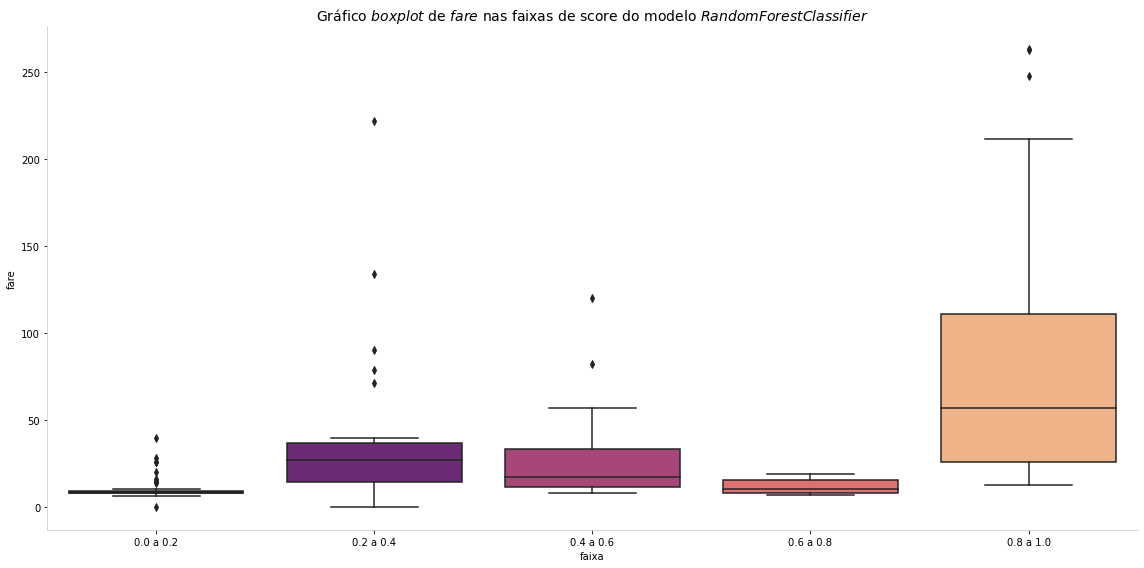

In [88]:
df_test = pd.DataFrame(X_test_prep, columns=features)
plot_feature_score_dist(data=df_test, feature='fare', model=model, kind='boxplot', save=True, 
                        output_path='output/imgs/models_eval', img_name='fare_score_distribution.png')

DEBUG;2020-11-22 20:28:05;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;34;Retornando probabilidades do modelo RandomForestClassifier
DEBUG;2020-11-22 20:28:06;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;42;Criando faixas com as probabilidades obtidas
DEBUG;2020-11-22 20:28:06;<ipython-input-86-4765bc43ffc6>;<ipython-input-86-4765bc43ffc6>;51;Plotando análise de distribuição para a variável age
DEBUG;2020-11-22 20:28:06;<ipython-input-55-9d2fe6b1067f>;<ipython-input-55-9d2fe6b1067f>;34;Salvando imagem no diretório especificado
INFO;2020-11-22 20:28:06;<ipython-input-55-9d2fe6b1067f>;<ipython-input-55-9d2fe6b1067f>;38;Imagem salva com sucesso em output/imgs/models_eval/age_score_distribution.png


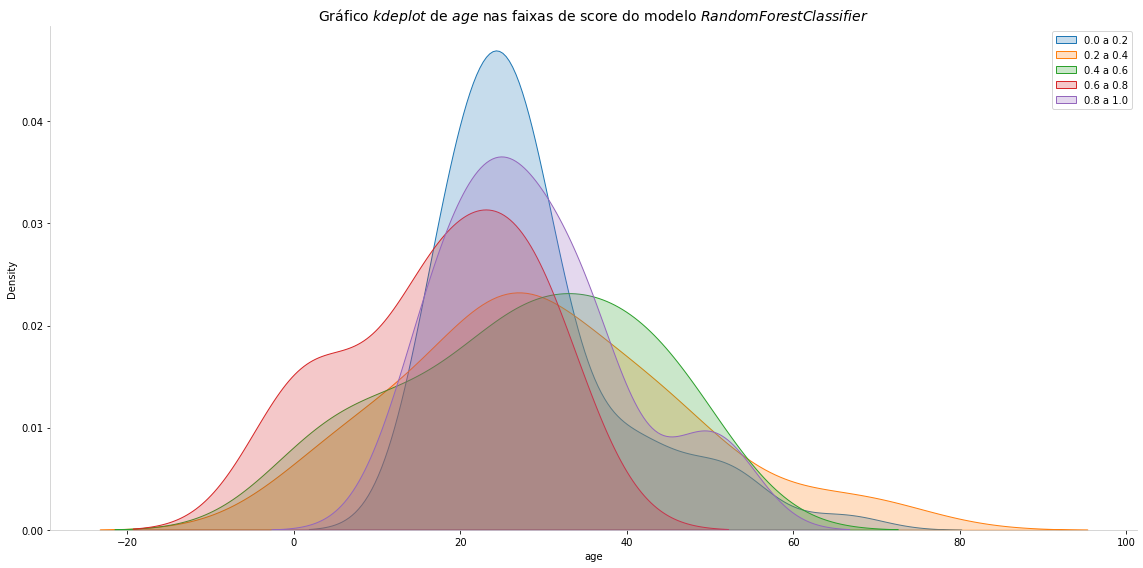

In [92]:
# Analisando variável "age"
plot_feature_score_dist(data=df_test, feature='age', model=model, kind='kdeplot', save=True, 
                        output_path='output/imgs/models_eval', img_name='age_score_distribution.png')